In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.autograd import Variable
import numpy as np

import cvxpy as cp
import MPC_prob
from utils import *
import pickle, os
from MPC_prob import MPC
from model_train import train

from tqdm import tqdm
from para import paraset
from sampling import sampling
import plot_route
from MPC_control import MPC_controller

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

C:\Users\msi\anaconda3\envs\coco\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\msi\anaconda3\envs\coco\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\msi\anaconda3\envs\coco\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


## Set prob parameters and save at MPC.config

In [2]:
N = 8
n_obs = 5
paraset(N=N,n_obs=n_obs,Qs=1,Rs=0,num_probs=20000,obs_default=True)

## Solve MICP problems to get samlpings for training

In [ ]:
sampling(N,n_obs)

## Load train/test data

### Test problem parameters

In [65]:
## test 10 problems
n_prob = 10

dataset_name = 'MPC_horizon_{}_obs_{}'.format(N,n_obs)
relative_path = os.getcwd()
config_fn = os.path.join(relative_path, 'config', dataset_name+'.p')
config_file = open(config_fn,'rb')
config=pickle.load(config_file)

prob = MPC(config=config_fn)

## set initial position and final position
# x0 = [3.5,1.75,0,0]
# xg = [2,2.5,0,0]

dataset_name, prob_params, sampled_params, n_obs, num_probs, border_size, box_buffer, min_box_size, max_box_size, posmin, posmax, velmin, velmax, n, m,obs_fix, xg_fix, obstacles = config

solvetime = 0
for i in range(n_prob):
    x0 = findIC(obstacles,posmin,posmax,velmin,velmax)
    xg = findIC(obstacles,posmin,posmax,velmin,velmax)

    prob_params = {}
    prob_params['obstacles'] =  np.reshape(np.concatenate(obstacles, axis=0), (n_obs,4)).T
    prob_params['x0'] = x0
    prob_params['xg'] = xg
    prob = MPC(config=config_fn)

    _, _, solvetime_g, optvals_g = prob.solve_stl(prob_params, solver=cp.GUROBI,verbose=False)
    solvetime += solvetime_g
print('Ava solve time for solving {} problems: '.format(n_prob) +str(solvetime/n_prob))

Ava solve time for solving 10 problems: 0.07499809265136718


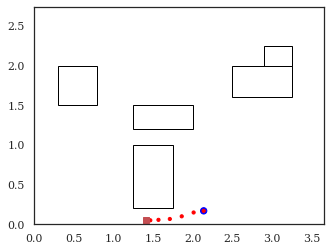

In [64]:
plot_route.plot(optvals_g,prob_params,N,n_obs)

### Load train/test data

In [66]:
#load train/test data
dataset_name = 'MPC_horizon_{}_obs_{}'.format(N,n_obs)

#加载设置文件地址，config = [dataset_name, prob_params, sampled_params]#
relative_path = os.getcwd()
config_fn = os.path.join(relative_path, 'config', dataset_name+'.p')

config_file = open(config_fn,'rb')
config=pickle.load(config_file)

dataset_name =  config[0]
prob_params = config[1]
sampled_params = config[2]
config_file.close()

### Load training&testing data

In [67]:
relative_path = os.getcwd()
dataset_name = 'MPC_horizon_{}_obs_{}'.format(N,n_obs)
dataset_fn = relative_path + '/data/' + dataset_name

##load train data
train_file = open(dataset_fn + '/train_horizon_{}.p'.format(N), 'rb')
# train_file = open(dataset_fn+'/train.p','rb')
train_data = pickle.load(train_file)
p_train, x_train, u_train, y_train, z_train, cost_train, times_train = train_data
train_file.close()

##load test data
test_file = open(dataset_fn + '/test_horizon_{}.p'.format(N), 'rb')
# test_file = open(dataset_fn+'/test.p','rb')
# p_test, x_test, u_test, y_test, c_test, times_test = pickle.load(test_file)
test_data = pickle.load(test_file)
p_test, x_test, u_test, y_test, z_test, cost_test, times_test = test_data
test_file.close()

### Load&set netwrok

In [68]:
from solvers.OMISTL import OMISTL

system = 'MPC'
prob_features = ['x0','xg','obstacles']
# prob_features = ['x0','xg','obstacles_map']
relative_path = os.getcwd()
config_fn = os.path.join(relative_path, 'config', dataset_name+'.p')
config_file = open(config_fn,'rb')
config=pickle.load(config_file)
prob = MPC(config=config_fn)

MPC_obj = OMISTL(system, prob, prob_features)

n_features = 2*prob.n*(len(prob_features)-1)+n_obs*4+n_obs

MPC_obj.construct_strategies(n_features, train_data)
print('Find number of strategires: '+ str(MPC_obj.n_strategies))

MPC_obj.setup_network()
fn_saved = '..\models/MPC_horizon_{}_obs_{}.pt'.format(N,n_obs)
MPC_obj.load_network(fn_saved)

Find number of strategires: 707
Loading presaved classifier model from ..\models/MPC_horizon_8_obs_5.pt


True

## Train model

In [ ]:
MPC_obj.training_params['TRAINING_ITERATIONS'] = 500
MPC_obj.train(train_data=train_data, verbose=True)
MPC_obj.model

### train model with different horizons

In [23]:
# train(N,n_obs)

nubmber of strategies:241
n_obs: 10
N: 6
Loading presaved classifier model from ..\models\MPC_horizon_6_obs_10.pt
model already exist


### Set problem and test dataset

In [123]:
velmin = -0.2
velmax = 0.2
posmin = np.zeros(2)

ft2m = 0.3048
posmax = ft2m*np.array([12.,9.])
max_box_size = 0.75
min_box_size = 0.25
box_buffer = 0.025
border_size = 0.05

obstacles = config[-1]
# obstacles = \
#         random_obs(n_obs, posmin, posmax, border_size, box_buffer, min_box_size, max_box_size)

## Calculating shortest path using network

In [124]:
prob_success = False
prob = MPC(config=config_fn)
## set initial position and final position
x0 = [3.5,1.75,0,0]
xg = [2,2.5,0,0]
# x0 = findIC(obstacles, posmin=posmin, posmax=posmax, velmin=velmin, velmax=velmax)
# xg = findIC(obstacles, posmin=posmin, posmax=posmax, velmin=velmin, velmax=velmax)

##
while not prob_success:
    prob_params = {}
    prob_params['obstacles'] =  np.reshape(np.concatenate(obstacles, axis=0), (n_obs,4)).T
    prob_params['x0'] = x0
    prob_params['xg'] = xg
    prob_success, cost, total_time, n_evals, optvals,y_guess = MPC_obj.forward(prob_params, solver=cp.GUROBI, max_evals=10)
    if prob_success:
        Xopt = optvals[0]

_, _, solvetime_g, optvals_g = prob.solve_stl(prob_params, solver=cp.GUROBI)
# _, _, solvetime_m, optvals_g = prob.solve_stl(prob_params, solver=cp.MOSEK)

print('Machine learning solve time (red points) : '+ str(total_time))
print('Gurobi solve time (blue points): '+ str(solvetime_g))
# print('MOSEK solve time: '+ str(solvetime_m))

Machine learning solve time (red points) : 0.015621185302734375
Gurobi solve time (blue points): 0.140625


## Plot

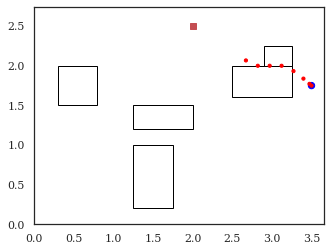

In [125]:
plot_route.plot(optvals,prob_params,N,n_obs)

## MPC control

### Set initial point and reference point

In [151]:
## set initial points and reference points
ref_list = []
num_ref = 3
x0 = [0.5,0.5,0,0]

#use default reference points
ref_1 = [0.6,2.3,0,0]
ref_list.append(ref_1)
ref_2 = [3.5,2.2,0,0]
ref_list.append(ref_2)
ref_3 = [3,1,0,0]
ref_list.append(ref_3)

# or generate reference points use different random seeds
# seed = 2
# for i in range(num_ref):
#     ref = list(findIC(obstacles, posmin=posmin, posmax=posmax, velmin=velmin, velmax=velmax, seed =i+seed))
#     ref[2]=0
#     ref[3]=0
#     ref_list.append(ref)
ref_list

[[0.6, 2.3, 0, 0], [3.5, 2.2, 0, 0], [3, 1, 0, 0]]

In [ ]:
mpc_time = 600
prob = MPC(config=config_fn)

Xopt,Uopt,Yopt,T_total = MPC_controller(x0,ref_list,prob=prob,MPC_obj=MPC_obj,T=mpc_time)

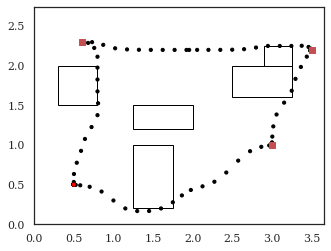

In [153]:
plot_route.plot_MPC(Xopt,ref_list,prob_params,N,n_obs)

In [154]:
print('total solving time for {} steps is '.format(mpc_time) +str(T_total))
print('avarage solving time at each step is ' +str(T_total/mpc_time))

total solving time for 600 steps is 3.2967357635498047
avarage solving time at each step is 0.005494559605916341
